In [58]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

##Loading Fashion Dataset.

In [59]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

In [60]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train=False, transform=ToTensor())

In [61]:
len(dataset)

60000

##Spliting train and dev set.

In [62]:
from torch.utils.data import random_split

In [63]:
train_ds, val_ds = random_split(dataset, [50000, 10000])

##Creating DataLoader

In [64]:
from torch.utils.data import DataLoader

In [65]:
train_loader = DataLoader(train_ds, batch_size = 64, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

##Creating Model

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [67]:
class FashionMnistModel1(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(784,256)
    self.linear2 = nn.Linear(256,10)
  
  def forward(self,xb):
    out = xb.view(xb.size(0), -1)
    
    output = self.linear1(out)
    output = F.relu(output)

    output = self.linear2(output)
    output = F.relu(output)

    return output
  
  def training_step(self,batch):
    images , labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss
  
  def validation_step(self,batch):
    images , labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss': loss , 'val_acc': acc}
  
  def validation_epoch_end(self,outputs):
    batch_loss = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [68]:
def accuracy(outputs,labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item() / len(preds))

##Connecting to GPU.

In [69]:
torch.cuda.is_available() 

False

In [70]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [71]:
device = get_default_device()
device

device(type='cpu')

In [72]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [73]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Moving data to GPU.

In [74]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

##Using the Created Model

In [75]:
def evaluate(model,val_dl):
  outputs = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(outputs)

In [76]:
def fit(epochs,lr,model,train_dl,val_dl,opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    for batch in train_dl:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    result = evaluate(model,val_dl)
    model.epoch_end(epoch,result)
    history.append(result)
  return history

In [77]:
model = FashionMnistModel1()
to_device(model,device)

FashionMnistModel1(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)

In [78]:
history1 = []
history2 = []
history3 = []
history4 = []
history5 = []
history1 = [evaluate(model, val_loader)]
history2 = [evaluate(model, val_loader)]
history3 = [evaluate(model, val_loader)]
history4 = [evaluate(model, val_loader)]
history5 = [evaluate(model, val_loader)]

In [79]:
history1 += fit(20, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.2704, val_acc: 0.2475
Epoch [1], val_loss: 2.2483, val_acc: 0.2944
Epoch [2], val_loss: 2.2267, val_acc: 0.3325
Epoch [3], val_loss: 2.2011, val_acc: 0.3627
Epoch [4], val_loss: 2.1748, val_acc: 0.3909
Epoch [5], val_loss: 2.1502, val_acc: 0.4130
Epoch [6], val_loss: 2.1262, val_acc: 0.4254
Epoch [7], val_loss: 2.1026, val_acc: 0.4336
Epoch [8], val_loss: 2.0794, val_acc: 0.4393
Epoch [9], val_loss: 2.0564, val_acc: 0.4443
Epoch [10], val_loss: 2.0337, val_acc: 0.4490
Epoch [11], val_loss: 2.0114, val_acc: 0.4523
Epoch [12], val_loss: 1.9896, val_acc: 0.4564
Epoch [13], val_loss: 1.9683, val_acc: 0.4627
Epoch [14], val_loss: 1.9475, val_acc: 0.4697
Epoch [15], val_loss: 1.9272, val_acc: 0.4767
Epoch [16], val_loss: 1.9075, val_acc: 0.4798
Epoch [17], val_loss: 1.8884, val_acc: 0.4844
Epoch [18], val_loss: 1.8698, val_acc: 0.4880
Epoch [19], val_loss: 1.8518, val_acc: 0.4903


In [80]:
model = FashionMnistModel1()
to_device(model,device)
history2 += fit(20, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.0791, val_acc: 0.4505
Epoch [1], val_loss: 1.8583, val_acc: 0.4863
Epoch [2], val_loss: 1.6755, val_acc: 0.5013
Epoch [3], val_loss: 1.5143, val_acc: 0.5088
Epoch [4], val_loss: 1.3401, val_acc: 0.5796
Epoch [5], val_loss: 1.2449, val_acc: 0.5855
Epoch [6], val_loss: 1.1814, val_acc: 0.5976
Epoch [7], val_loss: 1.1335, val_acc: 0.6071
Epoch [8], val_loss: 1.0955, val_acc: 0.6183
Epoch [9], val_loss: 1.0635, val_acc: 0.6312
Epoch [10], val_loss: 1.0358, val_acc: 0.6405
Epoch [11], val_loss: 1.0115, val_acc: 0.6472
Epoch [12], val_loss: 0.9898, val_acc: 0.6541
Epoch [13], val_loss: 0.9700, val_acc: 0.6603
Epoch [14], val_loss: 0.9528, val_acc: 0.6678
Epoch [15], val_loss: 0.9364, val_acc: 0.6738
Epoch [16], val_loss: 0.9226, val_acc: 0.6763
Epoch [17], val_loss: 0.9090, val_acc: 0.6832
Epoch [18], val_loss: 0.8976, val_acc: 0.6892
Epoch [19], val_loss: 0.8858, val_acc: 0.6923


In [81]:
model = FashionMnistModel1()
to_device(model,device)
history3 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.5451, val_acc: 0.4982
Epoch [1], val_loss: 1.2915, val_acc: 0.6085
Epoch [2], val_loss: 1.1674, val_acc: 0.6270
Epoch [3], val_loss: 1.1280, val_acc: 0.6307
Epoch [4], val_loss: 1.1040, val_acc: 0.6351
Epoch [5], val_loss: 1.0900, val_acc: 0.6371
Epoch [6], val_loss: 1.0812, val_acc: 0.6380
Epoch [7], val_loss: 1.0672, val_acc: 0.6417
Epoch [8], val_loss: 1.0601, val_acc: 0.6431
Epoch [9], val_loss: 1.0545, val_acc: 0.6443
Epoch [10], val_loss: 1.0563, val_acc: 0.6435
Epoch [11], val_loss: 1.0448, val_acc: 0.6460
Epoch [12], val_loss: 1.0414, val_acc: 0.6456
Epoch [13], val_loss: 1.0385, val_acc: 0.6448
Epoch [14], val_loss: 1.0305, val_acc: 0.6475
Epoch [15], val_loss: 1.0307, val_acc: 0.6476
Epoch [16], val_loss: 1.0340, val_acc: 0.6487
Epoch [17], val_loss: 1.0219, val_acc: 0.6479
Epoch [18], val_loss: 1.0277, val_acc: 0.6477
Epoch [19], val_loss: 1.0188, val_acc: 0.6472


In [82]:
model = FashionMnistModel1()
to_device(model,device)
history4 += fit(20, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5454, val_acc: 0.7949
Epoch [1], val_loss: 0.4871, val_acc: 0.8266
Epoch [2], val_loss: 0.4142, val_acc: 0.8495
Epoch [3], val_loss: 0.4763, val_acc: 0.8249
Epoch [4], val_loss: 0.4817, val_acc: 0.8273
Epoch [5], val_loss: 0.3936, val_acc: 0.8515
Epoch [6], val_loss: 0.3747, val_acc: 0.8590
Epoch [7], val_loss: 0.3566, val_acc: 0.8718
Epoch [8], val_loss: 0.3451, val_acc: 0.8724
Epoch [9], val_loss: 0.3463, val_acc: 0.8719
Epoch [10], val_loss: 0.4037, val_acc: 0.8490
Epoch [11], val_loss: 0.3617, val_acc: 0.8690
Epoch [12], val_loss: 0.4385, val_acc: 0.8532
Epoch [13], val_loss: 0.3410, val_acc: 0.8735
Epoch [14], val_loss: 0.3615, val_acc: 0.8713
Epoch [15], val_loss: 0.3827, val_acc: 0.8673
Epoch [16], val_loss: 0.4808, val_acc: 0.8217
Epoch [17], val_loss: 0.3348, val_acc: 0.8762
Epoch [18], val_loss: 0.3694, val_acc: 0.8664
Epoch [19], val_loss: 0.3300, val_acc: 0.8788


In [83]:
model = FashionMnistModel1()
to_device(model,device)
history5 += fit(20, 1, model, train_loader, val_loader)

Epoch [0], val_loss: 2.3026, val_acc: 0.1035
Epoch [1], val_loss: 2.3026, val_acc: 0.1035
Epoch [2], val_loss: 2.3026, val_acc: 0.1035
Epoch [3], val_loss: 2.3026, val_acc: 0.1035
Epoch [4], val_loss: 2.3026, val_acc: 0.1035
Epoch [5], val_loss: 2.3026, val_acc: 0.1035
Epoch [6], val_loss: 2.3026, val_acc: 0.1035
Epoch [7], val_loss: 2.3026, val_acc: 0.1035
Epoch [8], val_loss: 2.3026, val_acc: 0.1035
Epoch [9], val_loss: 2.3026, val_acc: 0.1035
Epoch [10], val_loss: 2.3026, val_acc: 0.1035
Epoch [11], val_loss: 2.3026, val_acc: 0.1035
Epoch [12], val_loss: 2.3026, val_acc: 0.1035
Epoch [13], val_loss: 2.3026, val_acc: 0.1035
Epoch [14], val_loss: 2.3026, val_acc: 0.1035
Epoch [15], val_loss: 2.3026, val_acc: 0.1035
Epoch [16], val_loss: 2.3026, val_acc: 0.1035
Epoch [17], val_loss: 2.3026, val_acc: 0.1035
Epoch [18], val_loss: 2.3026, val_acc: 0.1035
Epoch [19], val_loss: 2.3026, val_acc: 0.1035


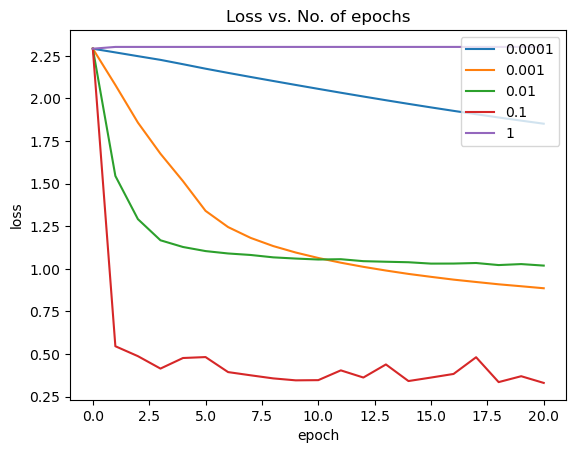

In [84]:
losses1 = [x['val_loss'] for x in history1]
losses2 = [x['val_loss'] for x in history2]
losses3 = [x['val_loss'] for x in history3]
losses4 = [x['val_loss'] for x in history4]
losses5 = [x['val_loss'] for x in history5]
plt.plot(losses1,label = '0.0001')
plt.plot(losses2,label = '0.001')
plt.plot(losses3,label = '0.01')
plt.plot(losses4,label = '0.1')
plt.plot(losses5,label = '1')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Loss vs. No. of epochs');

In [85]:
class FashionMnistModel2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(784,203)
    self.linear2 = nn.Linear(203,203)
    self.linear3 = nn.Linear(203,10)
  
  def forward(self,xb):
    out = xb.view(xb.size(0), -1)
    
    output = self.linear1(out)
    output = F.relu(output)

    output = self.linear2(output)
    output = F.relu(output)

    output = self.linear3(output)
    output = F.relu(output)

    return output
  
  def training_step(self,batch):
    images , labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss
  
  def validation_step(self,batch):
    images , labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss': loss , 'val_acc': acc}
  
  def validation_epoch_end(self,outputs):
    batch_loss = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [86]:
model = FashionMnistModel2()
to_device(model,device)

FashionMnistModel2(
  (linear1): Linear(in_features=784, out_features=203, bias=True)
  (linear2): Linear(in_features=203, out_features=203, bias=True)
  (linear3): Linear(in_features=203, out_features=10, bias=True)
)

In [87]:
history6 = []
history7 = []
history8 = []
history9 = []
history10 = []
history6 = [evaluate(model, val_loader)]
history7 = [evaluate(model, val_loader)]
history8 = [evaluate(model, val_loader)]
history9 = [evaluate(model, val_loader)]
history10 = [evaluate(model, val_loader)]

In [88]:
model = FashionMnistModel2()
to_device(model,device)
history6 += fit(20, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.2971, val_acc: 0.1457
Epoch [1], val_loss: 2.2933, val_acc: 0.1536
Epoch [2], val_loss: 2.2890, val_acc: 0.1664
Epoch [3], val_loss: 2.2848, val_acc: 0.1843
Epoch [4], val_loss: 2.2808, val_acc: 0.2106
Epoch [5], val_loss: 2.2768, val_acc: 0.2346
Epoch [6], val_loss: 2.2728, val_acc: 0.2546
Epoch [7], val_loss: 2.2687, val_acc: 0.2717
Epoch [8], val_loss: 2.2645, val_acc: 0.2822
Epoch [9], val_loss: 2.2601, val_acc: 0.2913
Epoch [10], val_loss: 2.2557, val_acc: 0.3026
Epoch [11], val_loss: 2.2511, val_acc: 0.3145
Epoch [12], val_loss: 2.2464, val_acc: 0.3259
Epoch [13], val_loss: 2.2415, val_acc: 0.3347
Epoch [14], val_loss: 2.2364, val_acc: 0.3420
Epoch [15], val_loss: 2.2312, val_acc: 0.3509
Epoch [16], val_loss: 2.2257, val_acc: 0.3549
Epoch [17], val_loss: 2.2198, val_acc: 0.3572
Epoch [18], val_loss: 2.2129, val_acc: 0.3575
Epoch [19], val_loss: 2.2048, val_acc: 0.3569


In [89]:
model = FashionMnistModel2()
to_device(model,device)
history7 += fit(20, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.2527, val_acc: 0.3262
Epoch [1], val_loss: 2.1841, val_acc: 0.4596
Epoch [2], val_loss: 2.0926, val_acc: 0.4885
Epoch [3], val_loss: 1.9756, val_acc: 0.4926
Epoch [4], val_loss: 1.8550, val_acc: 0.4991
Epoch [5], val_loss: 1.7540, val_acc: 0.5146
Epoch [6], val_loss: 1.6693, val_acc: 0.5197
Epoch [7], val_loss: 1.5976, val_acc: 0.5385
Epoch [8], val_loss: 1.5382, val_acc: 0.5426
Epoch [9], val_loss: 1.4911, val_acc: 0.5517
Epoch [10], val_loss: 1.4532, val_acc: 0.5538
Epoch [11], val_loss: 1.4232, val_acc: 0.5612
Epoch [12], val_loss: 1.3979, val_acc: 0.5645
Epoch [13], val_loss: 1.3764, val_acc: 0.5651
Epoch [14], val_loss: 1.3575, val_acc: 0.5704
Epoch [15], val_loss: 1.3410, val_acc: 0.5766
Epoch [16], val_loss: 1.3258, val_acc: 0.5822
Epoch [17], val_loss: 1.3117, val_acc: 0.5825
Epoch [18], val_loss: 1.2984, val_acc: 0.5907
Epoch [19], val_loss: 1.2859, val_acc: 0.5916


In [90]:
model = FashionMnistModel2()
to_device(model,device)
history8 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4133, val_acc: 0.5462
Epoch [1], val_loss: 1.1576, val_acc: 0.6022
Epoch [2], val_loss: 1.0665, val_acc: 0.6322
Epoch [3], val_loss: 0.9840, val_acc: 0.6642
Epoch [4], val_loss: 0.9510, val_acc: 0.6739
Epoch [5], val_loss: 1.0089, val_acc: 0.6386
Epoch [6], val_loss: 0.9284, val_acc: 0.6745
Epoch [7], val_loss: 0.8962, val_acc: 0.6858
Epoch [8], val_loss: 0.8736, val_acc: 0.6909
Epoch [9], val_loss: 0.9047, val_acc: 0.6737
Epoch [10], val_loss: 0.8611, val_acc: 0.6942
Epoch [11], val_loss: 0.8700, val_acc: 0.6904
Epoch [12], val_loss: 0.9000, val_acc: 0.6807
Epoch [13], val_loss: 0.8511, val_acc: 0.6973
Epoch [14], val_loss: 0.8546, val_acc: 0.6897
Epoch [15], val_loss: 0.8324, val_acc: 0.6984
Epoch [16], val_loss: 0.8334, val_acc: 0.6997
Epoch [17], val_loss: 0.8282, val_acc: 0.7019
Epoch [18], val_loss: 0.8320, val_acc: 0.6998
Epoch [19], val_loss: 0.8237, val_acc: 0.6998


In [91]:
model = FashionMnistModel2()
to_device(model,device)
history9 += fit(20, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 1.2318, val_acc: 0.5483
Epoch [1], val_loss: 1.0578, val_acc: 0.6191
Epoch [2], val_loss: 0.8815, val_acc: 0.6606
Epoch [3], val_loss: 0.8111, val_acc: 0.6859
Epoch [4], val_loss: 1.0841, val_acc: 0.5993
Epoch [5], val_loss: 0.8706, val_acc: 0.6528
Epoch [6], val_loss: 0.7989, val_acc: 0.6849
Epoch [7], val_loss: 0.7946, val_acc: 0.6893
Epoch [8], val_loss: 0.8736, val_acc: 0.6525
Epoch [9], val_loss: 0.7794, val_acc: 0.6893
Epoch [10], val_loss: 0.7554, val_acc: 0.6991
Epoch [11], val_loss: 0.7906, val_acc: 0.6850
Epoch [12], val_loss: 0.7911, val_acc: 0.6868
Epoch [13], val_loss: 0.8109, val_acc: 0.6806
Epoch [14], val_loss: 0.7857, val_acc: 0.6904
Epoch [15], val_loss: 0.7773, val_acc: 0.6930
Epoch [16], val_loss: 0.7459, val_acc: 0.7027
Epoch [17], val_loss: 0.7677, val_acc: 0.6983
Epoch [18], val_loss: 0.8206, val_acc: 0.6845
Epoch [19], val_loss: 0.7582, val_acc: 0.6982


In [92]:
model = FashionMnistModel2()
to_device(model,device)
history10 += fit(20, 1, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9234, val_acc: 0.2856
Epoch [1], val_loss: 1.6960, val_acc: 0.3722
Epoch [2], val_loss: 1.6946, val_acc: 0.3753
Epoch [3], val_loss: 1.7211, val_acc: 0.3619
Epoch [4], val_loss: 1.6760, val_acc: 0.3797
Epoch [5], val_loss: 1.7028, val_acc: 0.3736
Epoch [6], val_loss: 1.6916, val_acc: 0.3745
Epoch [7], val_loss: 1.9257, val_acc: 0.3471
Epoch [8], val_loss: 1.6738, val_acc: 0.3813
Epoch [9], val_loss: 1.6784, val_acc: 0.3800
Epoch [10], val_loss: 1.7185, val_acc: 0.3709
Epoch [11], val_loss: 1.6781, val_acc: 0.3826
Epoch [12], val_loss: 1.6835, val_acc: 0.3774
Epoch [13], val_loss: 1.6740, val_acc: 0.3816
Epoch [14], val_loss: 1.6759, val_acc: 0.3815
Epoch [15], val_loss: 2.0503, val_acc: 0.3424
Epoch [16], val_loss: 1.6793, val_acc: 0.3827
Epoch [17], val_loss: 2.0972, val_acc: 0.3225
Epoch [18], val_loss: 1.7420, val_acc: 0.3326
Epoch [19], val_loss: 1.6848, val_acc: 0.3816


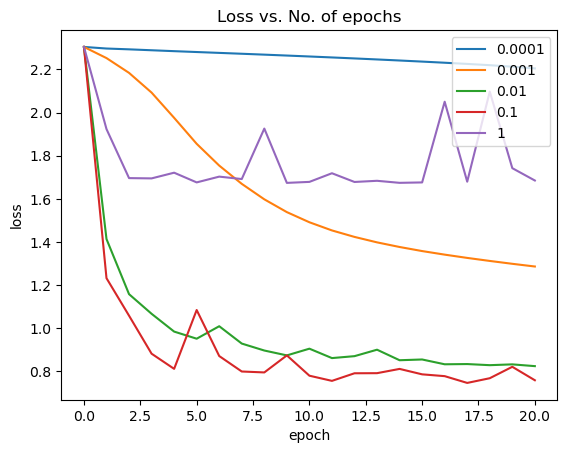

In [93]:
losses1 = [x['val_loss'] for x in history6]
losses2 = [x['val_loss'] for x in history7]
losses3 = [x['val_loss'] for x in history8]
losses4 = [x['val_loss'] for x in history9]
losses5 = [x['val_loss'] for x in history10]
plt.plot(losses1,label = '0.0001')
plt.plot(losses2,label = '0.001')
plt.plot(losses3,label = '0.01')
plt.plot(losses4,label = '0.1')
plt.plot(losses5,label = '1')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Loss vs. No. of epochs');

In [94]:
class FashionMnistModel3(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(784,176)
    self.linear2 = nn.Linear(176,176)
    self.linear3 = nn.Linear(176,176)
    self.linear4 = nn.Linear(176,10)
  
  def forward(self,xb):
    out = xb.view(xb.size(0), -1)
    
    output = self.linear1(out)
    output = F.relu(output)

    output = self.linear2(output)
    output = F.relu(output)

    output = self.linear3(output)
    output = F.relu(output)

    output = self.linear4(output)
    output = F.relu(output)

    return output
  
  def training_step(self,batch):
    images , labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss
  
  def validation_step(self,batch):
    images , labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss': loss , 'val_acc': acc}
  
  def validation_epoch_end(self,outputs):
    batch_loss = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [95]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [96]:
model = FashionMnistModel3()
to_device(model,device)

FashionMnistModel3(
  (linear1): Linear(in_features=784, out_features=176, bias=True)
  (linear2): Linear(in_features=176, out_features=176, bias=True)
  (linear3): Linear(in_features=176, out_features=176, bias=True)
  (linear4): Linear(in_features=176, out_features=10, bias=True)
)

In [97]:
history11 = []
history12=  []
history13 = []
history14 = []
history15 = []
history11 = [evaluate(model, val_loader)]
history12 = [evaluate(model, val_loader)]
history13 = [evaluate(model, val_loader)]
history14 = [evaluate(model, val_loader)]
history15 = [evaluate(model, val_loader)]

In [98]:
model = FashionMnistModel3()
to_device(model,device)
history11 += fit(20, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.3018, val_acc: 0.1401
Epoch [1], val_loss: 2.3011, val_acc: 0.1548
Epoch [2], val_loss: 2.3004, val_acc: 0.1673
Epoch [3], val_loss: 2.2997, val_acc: 0.1782
Epoch [4], val_loss: 2.2990, val_acc: 0.1880
Epoch [5], val_loss: 2.2983, val_acc: 0.1979
Epoch [6], val_loss: 2.2976, val_acc: 0.2089
Epoch [7], val_loss: 2.2970, val_acc: 0.2199
Epoch [8], val_loss: 2.2963, val_acc: 0.2317
Epoch [9], val_loss: 2.2956, val_acc: 0.2428
Epoch [10], val_loss: 2.2949, val_acc: 0.2569
Epoch [11], val_loss: 2.2942, val_acc: 0.2705
Epoch [12], val_loss: 2.2934, val_acc: 0.2824
Epoch [13], val_loss: 2.2927, val_acc: 0.2960
Epoch [14], val_loss: 2.2919, val_acc: 0.3058
Epoch [15], val_loss: 2.2911, val_acc: 0.3166
Epoch [16], val_loss: 2.2903, val_acc: 0.3261
Epoch [17], val_loss: 2.2895, val_acc: 0.3351
Epoch [18], val_loss: 2.2886, val_acc: 0.3427
Epoch [19], val_loss: 2.2878, val_acc: 0.3487


In [99]:
model = FashionMnistModel3()
to_device(model,device)
history12 += fit(20, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.2954, val_acc: 0.1006
Epoch [1], val_loss: 2.2858, val_acc: 0.2351
Epoch [2], val_loss: 2.2730, val_acc: 0.2704
Epoch [3], val_loss: 2.2546, val_acc: 0.2938
Epoch [4], val_loss: 2.2256, val_acc: 0.3493
Epoch [5], val_loss: 2.1772, val_acc: 0.3757
Epoch [6], val_loss: 2.0996, val_acc: 0.4143
Epoch [7], val_loss: 1.9847, val_acc: 0.4386
Epoch [8], val_loss: 1.8501, val_acc: 0.4142
Epoch [9], val_loss: 1.7301, val_acc: 0.4277
Epoch [10], val_loss: 1.6387, val_acc: 0.4409
Epoch [11], val_loss: 1.5679, val_acc: 0.4496
Epoch [12], val_loss: 1.5085, val_acc: 0.4587
Epoch [13], val_loss: 1.4582, val_acc: 0.4686
Epoch [14], val_loss: 1.4169, val_acc: 0.4711
Epoch [15], val_loss: 1.3843, val_acc: 0.4766
Epoch [16], val_loss: 1.3582, val_acc: 0.4830
Epoch [17], val_loss: 1.3372, val_acc: 0.4850
Epoch [18], val_loss: 1.3202, val_acc: 0.4853
Epoch [19], val_loss: 1.3057, val_acc: 0.4892


In [100]:
model = FashionMnistModel3()
to_device(model,device)
history13 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.6682, val_acc: 0.4571
Epoch [1], val_loss: 1.1808, val_acc: 0.5210
Epoch [2], val_loss: 1.0099, val_acc: 0.6368
Epoch [3], val_loss: 0.8333, val_acc: 0.7022
Epoch [4], val_loss: 0.7987, val_acc: 0.7171
Epoch [5], val_loss: 0.8001, val_acc: 0.7221
Epoch [6], val_loss: 0.7667, val_acc: 0.7298
Epoch [7], val_loss: 0.7236, val_acc: 0.7443
Epoch [8], val_loss: 0.6879, val_acc: 0.7589
Epoch [9], val_loss: 0.6776, val_acc: 0.7620
Epoch [10], val_loss: 0.6646, val_acc: 0.7650
Epoch [11], val_loss: 0.6507, val_acc: 0.7697
Epoch [12], val_loss: 0.6786, val_acc: 0.7580
Epoch [13], val_loss: 0.6503, val_acc: 0.7698
Epoch [14], val_loss: 0.7002, val_acc: 0.7448
Epoch [15], val_loss: 0.6714, val_acc: 0.7525
Epoch [16], val_loss: 0.6879, val_acc: 0.7458
Epoch [17], val_loss: 0.6190, val_acc: 0.7715
Epoch [18], val_loss: 0.6230, val_acc: 0.7735
Epoch [19], val_loss: 0.6339, val_acc: 0.7653


In [101]:
model = FashionMnistModel3()
to_device(model,device)
history14 += fit(20, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.9766, val_acc: 0.6319
Epoch [1], val_loss: 0.8703, val_acc: 0.6886
Epoch [2], val_loss: 0.6431, val_acc: 0.7655
Epoch [3], val_loss: 0.6547, val_acc: 0.7535
Epoch [4], val_loss: 0.7739, val_acc: 0.7120
Epoch [5], val_loss: 0.6604, val_acc: 0.7616
Epoch [6], val_loss: 0.4398, val_acc: 0.8402
Epoch [7], val_loss: 1.0209, val_acc: 0.7537
Epoch [8], val_loss: 0.3782, val_acc: 0.8518
Epoch [9], val_loss: 0.3873, val_acc: 0.8574
Epoch [10], val_loss: 0.3807, val_acc: 0.8589
Epoch [11], val_loss: 0.4076, val_acc: 0.8599
Epoch [12], val_loss: 0.3239, val_acc: 0.8829
Epoch [13], val_loss: 0.3348, val_acc: 0.8765
Epoch [14], val_loss: 0.3286, val_acc: 0.8737
Epoch [15], val_loss: 0.3244, val_acc: 0.8812
Epoch [16], val_loss: 0.5356, val_acc: 0.8380
Epoch [17], val_loss: 0.4435, val_acc: 0.8336
Epoch [18], val_loss: 0.3712, val_acc: 0.8633
Epoch [19], val_loss: 0.6347, val_acc: 0.8084


In [102]:
model = FashionMnistModel3()
to_device(model,device)
history15 += fit(20, 1, model, train_loader, val_loader)

Epoch [0], val_loss: 2.1288, val_acc: 0.1911
Epoch [1], val_loss: 2.1086, val_acc: 0.1960
Epoch [2], val_loss: 2.1068, val_acc: 0.1962
Epoch [3], val_loss: 2.1016, val_acc: 0.1973
Epoch [4], val_loss: 2.1009, val_acc: 0.1967
Epoch [5], val_loss: 2.1004, val_acc: 0.1983
Epoch [6], val_loss: 2.1293, val_acc: 0.1989
Epoch [7], val_loss: 2.0982, val_acc: 0.1983
Epoch [8], val_loss: 2.1150, val_acc: 0.1988
Epoch [9], val_loss: 2.1529, val_acc: 0.1741
Epoch [10], val_loss: 2.1035, val_acc: 0.1953
Epoch [11], val_loss: 2.0992, val_acc: 0.1971
Epoch [12], val_loss: 2.1007, val_acc: 0.1971
Epoch [13], val_loss: 2.1038, val_acc: 0.1952
Epoch [14], val_loss: 2.0972, val_acc: 0.1981
Epoch [15], val_loss: 2.1034, val_acc: 0.1951
Epoch [16], val_loss: 2.0996, val_acc: 0.1969
Epoch [17], val_loss: 2.1234, val_acc: 0.1984
Epoch [18], val_loss: 2.0973, val_acc: 0.1969
Epoch [19], val_loss: 2.1076, val_acc: 0.1943


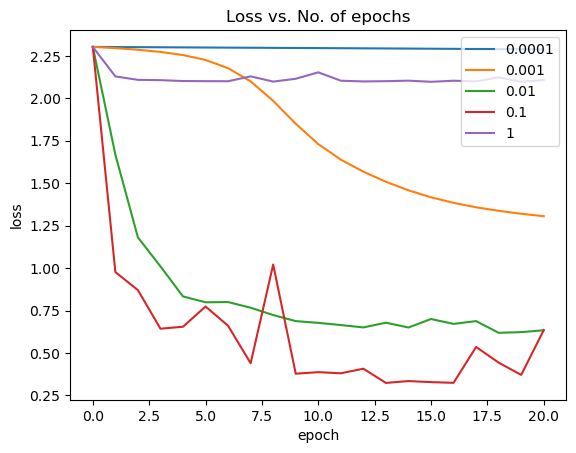

In [103]:
losses1 = [x['val_loss'] for x in history11]
losses2 = [x['val_loss'] for x in history12]
losses3 = [x['val_loss'] for x in history13]
losses4 = [x['val_loss'] for x in history14]
losses5 = [x['val_loss'] for x in history15]
plt.plot(losses1,label = '0.0001')
plt.plot(losses2,label = '0.001')
plt.plot(losses3,label = '0.01')
plt.plot(losses4,label = '0.1')
plt.plot(losses5,label = '1')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Loss vs. No. of epochs');

Now Changing the batch size

For Model 1

In [104]:
train_loader = DataLoader(train_ds, batch_size = 16, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [105]:
model = FashionMnistModel1()
to_device(model,device)

FashionMnistModel1(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)

In [106]:
new_history1 = []
new_history2 = []
new_history3 = []
new_history4 = []
new_history5 = []
new_history1 = [evaluate(model, val_loader)]
new_history2 = [evaluate(model, val_loader)]
new_history3 = [evaluate(model, val_loader)]
new_history4= [evaluate(model, val_loader)]
new_history5 = [evaluate(model, val_loader)]

In [107]:
train_loader = DataLoader(train_ds, batch_size = 16, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [108]:
new_history1 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7518, val_acc: 0.7450
Epoch [1], val_loss: 0.7086, val_acc: 0.7453
Epoch [2], val_loss: 0.6513, val_acc: 0.7721
Epoch [3], val_loss: 0.6280, val_acc: 0.7766
Epoch [4], val_loss: 0.6541, val_acc: 0.7683
Epoch [5], val_loss: 0.6214, val_acc: 0.7771
Epoch [6], val_loss: 0.6078, val_acc: 0.7816
Epoch [7], val_loss: 0.6129, val_acc: 0.7805
Epoch [8], val_loss: 0.5797, val_acc: 0.7884
Epoch [9], val_loss: 0.5808, val_acc: 0.7883
Epoch [10], val_loss: 0.5773, val_acc: 0.7912
Epoch [11], val_loss: 0.5869, val_acc: 0.7843
Epoch [12], val_loss: 0.5706, val_acc: 0.7923
Epoch [13], val_loss: 0.5650, val_acc: 0.7920
Epoch [14], val_loss: 0.5566, val_acc: 0.7961
Epoch [15], val_loss: 0.5517, val_acc: 0.7984
Epoch [16], val_loss: 0.5437, val_acc: 0.8014
Epoch [17], val_loss: 0.5487, val_acc: 0.7973
Epoch [18], val_loss: 0.3682, val_acc: 0.8706
Epoch [19], val_loss: 0.3583, val_acc: 0.8742


In [109]:
train_loader = DataLoader(train_ds, batch_size = 64, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [110]:
new_history2 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3384, val_acc: 0.8815
Epoch [1], val_loss: 0.3400, val_acc: 0.8806
Epoch [2], val_loss: 0.3413, val_acc: 0.8817
Epoch [3], val_loss: 0.3381, val_acc: 0.8800
Epoch [4], val_loss: 0.3327, val_acc: 0.8818
Epoch [5], val_loss: 0.3362, val_acc: 0.8818
Epoch [6], val_loss: 0.3373, val_acc: 0.8787
Epoch [7], val_loss: 0.3323, val_acc: 0.8843
Epoch [8], val_loss: 0.3349, val_acc: 0.8816
Epoch [9], val_loss: 0.3312, val_acc: 0.8807
Epoch [10], val_loss: 0.3306, val_acc: 0.8808
Epoch [11], val_loss: 0.3306, val_acc: 0.8826
Epoch [12], val_loss: 0.3300, val_acc: 0.8831
Epoch [13], val_loss: 0.3359, val_acc: 0.8827
Epoch [14], val_loss: 0.3358, val_acc: 0.8808
Epoch [15], val_loss: 0.3279, val_acc: 0.8844
Epoch [16], val_loss: 0.3261, val_acc: 0.8862
Epoch [17], val_loss: 0.3248, val_acc: 0.8842
Epoch [18], val_loss: 0.3272, val_acc: 0.8839
Epoch [19], val_loss: 0.3266, val_acc: 0.8835


In [111]:
train_loader = DataLoader(train_ds, batch_size = 256, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [112]:
new_history3 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3223, val_acc: 0.8861
Epoch [1], val_loss: 0.3231, val_acc: 0.8843
Epoch [2], val_loss: 0.3227, val_acc: 0.8871
Epoch [3], val_loss: 0.3215, val_acc: 0.8871
Epoch [4], val_loss: 0.3229, val_acc: 0.8839
Epoch [5], val_loss: 0.3215, val_acc: 0.8867
Epoch [6], val_loss: 0.3257, val_acc: 0.8856
Epoch [7], val_loss: 0.3214, val_acc: 0.8848
Epoch [8], val_loss: 0.3214, val_acc: 0.8856
Epoch [9], val_loss: 0.3236, val_acc: 0.8843
Epoch [10], val_loss: 0.3214, val_acc: 0.8863
Epoch [11], val_loss: 0.3223, val_acc: 0.8843
Epoch [12], val_loss: 0.3208, val_acc: 0.8858
Epoch [13], val_loss: 0.3204, val_acc: 0.8862
Epoch [14], val_loss: 0.3202, val_acc: 0.8863
Epoch [15], val_loss: 0.3232, val_acc: 0.8839
Epoch [16], val_loss: 0.3212, val_acc: 0.8866
Epoch [17], val_loss: 0.3201, val_acc: 0.8850
Epoch [18], val_loss: 0.3218, val_acc: 0.8869
Epoch [19], val_loss: 0.3199, val_acc: 0.8867


In [113]:
train_loader = DataLoader(train_ds, batch_size = 1024, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [114]:
new_history4 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3194, val_acc: 0.8863
Epoch [1], val_loss: 0.3195, val_acc: 0.8862
Epoch [2], val_loss: 0.3195, val_acc: 0.8866
Epoch [3], val_loss: 0.3197, val_acc: 0.8866
Epoch [4], val_loss: 0.3197, val_acc: 0.8853
Epoch [5], val_loss: 0.3191, val_acc: 0.8865
Epoch [6], val_loss: 0.3192, val_acc: 0.8867
Epoch [7], val_loss: 0.3191, val_acc: 0.8872
Epoch [8], val_loss: 0.3196, val_acc: 0.8864
Epoch [9], val_loss: 0.3196, val_acc: 0.8870
Epoch [10], val_loss: 0.3193, val_acc: 0.8866
Epoch [11], val_loss: 0.3190, val_acc: 0.8866
Epoch [12], val_loss: 0.3191, val_acc: 0.8864
Epoch [13], val_loss: 0.3190, val_acc: 0.8858
Epoch [14], val_loss: 0.3188, val_acc: 0.8868
Epoch [15], val_loss: 0.3194, val_acc: 0.8864
Epoch [16], val_loss: 0.3188, val_acc: 0.8870
Epoch [17], val_loss: 0.3193, val_acc: 0.8864
Epoch [18], val_loss: 0.3187, val_acc: 0.8869
Epoch [19], val_loss: 0.3187, val_acc: 0.8868


In [115]:
train_loader = DataLoader(train_ds, batch_size = 2048, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [116]:
new_history5 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3189, val_acc: 0.8865
Epoch [1], val_loss: 0.3190, val_acc: 0.8860
Epoch [2], val_loss: 0.3189, val_acc: 0.8866
Epoch [3], val_loss: 0.3188, val_acc: 0.8868
Epoch [4], val_loss: 0.3188, val_acc: 0.8870
Epoch [5], val_loss: 0.3187, val_acc: 0.8869
Epoch [6], val_loss: 0.3187, val_acc: 0.8863
Epoch [7], val_loss: 0.3188, val_acc: 0.8865
Epoch [8], val_loss: 0.3186, val_acc: 0.8864
Epoch [9], val_loss: 0.3185, val_acc: 0.8866
Epoch [10], val_loss: 0.3189, val_acc: 0.8868
Epoch [11], val_loss: 0.3187, val_acc: 0.8869
Epoch [12], val_loss: 0.3186, val_acc: 0.8865
Epoch [13], val_loss: 0.3187, val_acc: 0.8859
Epoch [14], val_loss: 0.3184, val_acc: 0.8870
Epoch [15], val_loss: 0.3187, val_acc: 0.8868
Epoch [16], val_loss: 0.3186, val_acc: 0.8870
Epoch [17], val_loss: 0.3186, val_acc: 0.8877
Epoch [18], val_loss: 0.3184, val_acc: 0.8864
Epoch [19], val_loss: 0.3185, val_acc: 0.8871


For Model 2

In [117]:
model = FashionMnistModel2()
to_device(model,device)

FashionMnistModel2(
  (linear1): Linear(in_features=784, out_features=203, bias=True)
  (linear2): Linear(in_features=203, out_features=203, bias=True)
  (linear3): Linear(in_features=203, out_features=10, bias=True)
)

In [118]:
new_history6 = []
new_history7= []
new_history8 = []
new_history9 = []
new_history10 = []
new_history6 = [evaluate(model, val_loader)]
new_history7 = [evaluate(model, val_loader)]
new_history8 = [evaluate(model, val_loader)]
new_history9= [evaluate(model, val_loader)]
new_history10 = [evaluate(model, val_loader)]

In [119]:
train_loader = DataLoader(train_ds, batch_size = 16, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [120]:
new_history6 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5700, val_acc: 0.8024
Epoch [1], val_loss: 0.4835, val_acc: 0.8342
Epoch [2], val_loss: 0.4570, val_acc: 0.8399
Epoch [3], val_loss: 0.4434, val_acc: 0.8393
Epoch [4], val_loss: 0.4117, val_acc: 0.8546
Epoch [5], val_loss: 0.4104, val_acc: 0.8525
Epoch [6], val_loss: 0.3836, val_acc: 0.8622
Epoch [7], val_loss: 0.3734, val_acc: 0.8633
Epoch [8], val_loss: 0.3777, val_acc: 0.8630
Epoch [9], val_loss: 0.3718, val_acc: 0.8655
Epoch [10], val_loss: 0.3531, val_acc: 0.8699
Epoch [11], val_loss: 0.3408, val_acc: 0.8754
Epoch [12], val_loss: 0.3493, val_acc: 0.8723
Epoch [13], val_loss: 0.3289, val_acc: 0.8793
Epoch [14], val_loss: 0.3532, val_acc: 0.8715
Epoch [15], val_loss: 0.3418, val_acc: 0.8763
Epoch [16], val_loss: 0.3328, val_acc: 0.8800
Epoch [17], val_loss: 0.3302, val_acc: 0.8795
Epoch [18], val_loss: 0.3248, val_acc: 0.8786
Epoch [19], val_loss: 0.3356, val_acc: 0.8759


In [121]:
train_loader = DataLoader(train_ds, batch_size = 64, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [122]:
new_history7 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3095, val_acc: 0.8842
Epoch [1], val_loss: 0.3064, val_acc: 0.8869
Epoch [2], val_loss: 0.3100, val_acc: 0.8848
Epoch [3], val_loss: 0.3087, val_acc: 0.8867
Epoch [4], val_loss: 0.3039, val_acc: 0.8874
Epoch [5], val_loss: 0.3126, val_acc: 0.8824
Epoch [6], val_loss: 0.3081, val_acc: 0.8859
Epoch [7], val_loss: 0.3107, val_acc: 0.8860
Epoch [8], val_loss: 0.3024, val_acc: 0.8895
Epoch [9], val_loss: 0.3009, val_acc: 0.8902
Epoch [10], val_loss: 0.3131, val_acc: 0.8853
Epoch [11], val_loss: 0.3082, val_acc: 0.8872
Epoch [12], val_loss: 0.3080, val_acc: 0.8866
Epoch [13], val_loss: 0.3023, val_acc: 0.8885
Epoch [14], val_loss: 0.3103, val_acc: 0.8857
Epoch [15], val_loss: 0.3137, val_acc: 0.8841
Epoch [16], val_loss: 0.3142, val_acc: 0.8865
Epoch [17], val_loss: 0.3047, val_acc: 0.8902
Epoch [18], val_loss: 0.3117, val_acc: 0.8874
Epoch [19], val_loss: 0.3084, val_acc: 0.8876


In [123]:
train_loader = DataLoader(train_ds, batch_size = 256, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [124]:
new_history8 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2977, val_acc: 0.8920
Epoch [1], val_loss: 0.2953, val_acc: 0.8934
Epoch [2], val_loss: 0.2959, val_acc: 0.8926
Epoch [3], val_loss: 0.3064, val_acc: 0.8891
Epoch [4], val_loss: 0.2950, val_acc: 0.8931
Epoch [5], val_loss: 0.2952, val_acc: 0.8921
Epoch [6], val_loss: 0.2973, val_acc: 0.8935
Epoch [7], val_loss: 0.2965, val_acc: 0.8940
Epoch [8], val_loss: 0.2965, val_acc: 0.8912
Epoch [9], val_loss: 0.2994, val_acc: 0.8929
Epoch [10], val_loss: 0.2997, val_acc: 0.8910
Epoch [11], val_loss: 0.2961, val_acc: 0.8915
Epoch [12], val_loss: 0.2987, val_acc: 0.8895
Epoch [13], val_loss: 0.2968, val_acc: 0.8917
Epoch [14], val_loss: 0.2988, val_acc: 0.8915
Epoch [15], val_loss: 0.3008, val_acc: 0.8905
Epoch [16], val_loss: 0.2980, val_acc: 0.8928
Epoch [17], val_loss: 0.3010, val_acc: 0.8922
Epoch [18], val_loss: 0.2976, val_acc: 0.8916
Epoch [19], val_loss: 0.2970, val_acc: 0.8925


In [125]:
train_loader = DataLoader(train_ds, batch_size = 1024, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [126]:
new_history9 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2949, val_acc: 0.8947
Epoch [1], val_loss: 0.2950, val_acc: 0.8945
Epoch [2], val_loss: 0.2949, val_acc: 0.8934
Epoch [3], val_loss: 0.2949, val_acc: 0.8952
Epoch [4], val_loss: 0.2952, val_acc: 0.8945
Epoch [5], val_loss: 0.2952, val_acc: 0.8943
Epoch [6], val_loss: 0.2948, val_acc: 0.8943
Epoch [7], val_loss: 0.2955, val_acc: 0.8940
Epoch [8], val_loss: 0.2952, val_acc: 0.8941
Epoch [9], val_loss: 0.2949, val_acc: 0.8944
Epoch [10], val_loss: 0.2955, val_acc: 0.8946
Epoch [11], val_loss: 0.2953, val_acc: 0.8937
Epoch [12], val_loss: 0.2959, val_acc: 0.8929
Epoch [13], val_loss: 0.2955, val_acc: 0.8927
Epoch [14], val_loss: 0.2954, val_acc: 0.8930
Epoch [15], val_loss: 0.2956, val_acc: 0.8951
Epoch [16], val_loss: 0.2956, val_acc: 0.8933
Epoch [17], val_loss: 0.2961, val_acc: 0.8927
Epoch [18], val_loss: 0.2956, val_acc: 0.8950
Epoch [19], val_loss: 0.2959, val_acc: 0.8949


In [127]:
train_loader = DataLoader(train_ds, batch_size = 2048, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [128]:
new_history10 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2964, val_acc: 0.8952
Epoch [1], val_loss: 0.2949, val_acc: 0.8953
Epoch [2], val_loss: 0.2952, val_acc: 0.8939
Epoch [3], val_loss: 0.2955, val_acc: 0.8936
Epoch [4], val_loss: 0.2959, val_acc: 0.8929
Epoch [5], val_loss: 0.2957, val_acc: 0.8928
Epoch [6], val_loss: 0.2951, val_acc: 0.8937
Epoch [7], val_loss: 0.2951, val_acc: 0.8942
Epoch [8], val_loss: 0.2953, val_acc: 0.8942
Epoch [9], val_loss: 0.2955, val_acc: 0.8940
Epoch [10], val_loss: 0.2956, val_acc: 0.8934
Epoch [11], val_loss: 0.2957, val_acc: 0.8950
Epoch [12], val_loss: 0.2951, val_acc: 0.8942
Epoch [13], val_loss: 0.2954, val_acc: 0.8946
Epoch [14], val_loss: 0.2953, val_acc: 0.8945
Epoch [15], val_loss: 0.2954, val_acc: 0.8933
Epoch [16], val_loss: 0.2952, val_acc: 0.8943
Epoch [17], val_loss: 0.2952, val_acc: 0.8933
Epoch [18], val_loss: 0.2955, val_acc: 0.8921
Epoch [19], val_loss: 0.2957, val_acc: 0.8932


For Model 3

In [129]:
model = FashionMnistModel3()
to_device(model,device)

FashionMnistModel3(
  (linear1): Linear(in_features=784, out_features=176, bias=True)
  (linear2): Linear(in_features=176, out_features=176, bias=True)
  (linear3): Linear(in_features=176, out_features=176, bias=True)
  (linear4): Linear(in_features=176, out_features=10, bias=True)
)

In [130]:
new_history11 = []
new_history12 = []
new_history13 = []
new_history14 = []
new_history15 = []
new_history11 = [evaluate(model, val_loader)]
new_history12 = [evaluate(model, val_loader)]
new_history13 = [evaluate(model, val_loader)]
new_history14= [evaluate(model, val_loader)]
new_history15 = [evaluate(model, val_loader)]

In [131]:
train_loader = DataLoader(train_ds, batch_size = 16, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [132]:
new_history11 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1562, val_acc: 0.6176
Epoch [1], val_loss: 0.9883, val_acc: 0.7144
Epoch [2], val_loss: 0.8488, val_acc: 0.7178
Epoch [3], val_loss: 0.8144, val_acc: 0.7239
Epoch [4], val_loss: 0.7886, val_acc: 0.7336
Epoch [5], val_loss: 0.7790, val_acc: 0.7372
Epoch [6], val_loss: 0.7600, val_acc: 0.7431
Epoch [7], val_loss: 0.6142, val_acc: 0.8164
Epoch [8], val_loss: 0.6094, val_acc: 0.8137
Epoch [9], val_loss: 0.3913, val_acc: 0.8611
Epoch [10], val_loss: 0.3818, val_acc: 0.8585
Epoch [11], val_loss: 0.3550, val_acc: 0.8698
Epoch [12], val_loss: 0.3820, val_acc: 0.8606
Epoch [13], val_loss: 0.3903, val_acc: 0.8560
Epoch [14], val_loss: 0.3416, val_acc: 0.8716
Epoch [15], val_loss: 0.3303, val_acc: 0.8786
Epoch [16], val_loss: 0.3298, val_acc: 0.8782
Epoch [17], val_loss: 0.3287, val_acc: 0.8803
Epoch [18], val_loss: 0.3276, val_acc: 0.8810
Epoch [19], val_loss: 0.3286, val_acc: 0.8814


In [133]:
train_loader = DataLoader(train_ds, batch_size = 64, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [134]:
new_history12 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3351, val_acc: 0.8773
Epoch [1], val_loss: 0.3221, val_acc: 0.8846
Epoch [2], val_loss: 0.3163, val_acc: 0.8858
Epoch [3], val_loss: 0.3030, val_acc: 0.8907
Epoch [4], val_loss: 0.3007, val_acc: 0.8911
Epoch [5], val_loss: 0.3213, val_acc: 0.8812
Epoch [6], val_loss: 0.3055, val_acc: 0.8894
Epoch [7], val_loss: 0.3036, val_acc: 0.8908
Epoch [8], val_loss: 0.3073, val_acc: 0.8882
Epoch [9], val_loss: 0.3023, val_acc: 0.8903
Epoch [10], val_loss: 0.3012, val_acc: 0.8930
Epoch [11], val_loss: 0.3034, val_acc: 0.8922
Epoch [12], val_loss: 0.3048, val_acc: 0.8922
Epoch [13], val_loss: 0.3105, val_acc: 0.8908
Epoch [14], val_loss: 0.3017, val_acc: 0.8943
Epoch [15], val_loss: 0.3158, val_acc: 0.8871
Epoch [16], val_loss: 0.3254, val_acc: 0.8867
Epoch [17], val_loss: 0.3000, val_acc: 0.8902
Epoch [18], val_loss: 0.3052, val_acc: 0.8925
Epoch [19], val_loss: 0.3359, val_acc: 0.8780


In [135]:
train_loader = DataLoader(train_ds, batch_size = 256, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [136]:
new_history13 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3027, val_acc: 0.8943
Epoch [1], val_loss: 0.3010, val_acc: 0.8940
Epoch [2], val_loss: 0.3016, val_acc: 0.8935
Epoch [3], val_loss: 0.3126, val_acc: 0.8921
Epoch [4], val_loss: 0.3019, val_acc: 0.8937
Epoch [5], val_loss: 0.3061, val_acc: 0.8926
Epoch [6], val_loss: 0.3048, val_acc: 0.8928
Epoch [7], val_loss: 0.3034, val_acc: 0.8935
Epoch [8], val_loss: 0.3056, val_acc: 0.8928
Epoch [9], val_loss: 0.3044, val_acc: 0.8935
Epoch [10], val_loss: 0.3047, val_acc: 0.8935
Epoch [11], val_loss: 0.3045, val_acc: 0.8930
Epoch [12], val_loss: 0.3088, val_acc: 0.8916
Epoch [13], val_loss: 0.3021, val_acc: 0.8945
Epoch [14], val_loss: 0.3080, val_acc: 0.8925
Epoch [15], val_loss: 0.3072, val_acc: 0.8944
Epoch [16], val_loss: 0.3216, val_acc: 0.8898
Epoch [17], val_loss: 0.3051, val_acc: 0.8934
Epoch [18], val_loss: 0.3053, val_acc: 0.8937
Epoch [19], val_loss: 0.3079, val_acc: 0.8916


In [137]:
train_loader = DataLoader(train_ds, batch_size = 1024, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [138]:
new_history14 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3038, val_acc: 0.8953
Epoch [1], val_loss: 0.3044, val_acc: 0.8943
Epoch [2], val_loss: 0.3043, val_acc: 0.8940
Epoch [3], val_loss: 0.3044, val_acc: 0.8946
Epoch [4], val_loss: 0.3041, val_acc: 0.8936
Epoch [5], val_loss: 0.3044, val_acc: 0.8940
Epoch [6], val_loss: 0.3050, val_acc: 0.8951
Epoch [7], val_loss: 0.3059, val_acc: 0.8920
Epoch [8], val_loss: 0.3052, val_acc: 0.8928
Epoch [9], val_loss: 0.3055, val_acc: 0.8942
Epoch [10], val_loss: 0.3044, val_acc: 0.8937
Epoch [11], val_loss: 0.3050, val_acc: 0.8919
Epoch [12], val_loss: 0.3046, val_acc: 0.8943
Epoch [13], val_loss: 0.3047, val_acc: 0.8943
Epoch [14], val_loss: 0.3052, val_acc: 0.8944
Epoch [15], val_loss: 0.3065, val_acc: 0.8950
Epoch [16], val_loss: 0.3056, val_acc: 0.8937
Epoch [17], val_loss: 0.3056, val_acc: 0.8945
Epoch [18], val_loss: 0.3053, val_acc: 0.8938
Epoch [19], val_loss: 0.3059, val_acc: 0.8938


In [139]:
train_loader = DataLoader(train_ds, batch_size = 2048, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [140]:
new_history15 += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3067, val_acc: 0.8927
Epoch [1], val_loss: 0.3058, val_acc: 0.8940
Epoch [2], val_loss: 0.3073, val_acc: 0.8926
Epoch [3], val_loss: 0.3054, val_acc: 0.8945
Epoch [4], val_loss: 0.3063, val_acc: 0.8941
Epoch [5], val_loss: 0.3058, val_acc: 0.8937
Epoch [6], val_loss: 0.3057, val_acc: 0.8935
Epoch [7], val_loss: 0.3061, val_acc: 0.8934
Epoch [8], val_loss: 0.3063, val_acc: 0.8940
Epoch [9], val_loss: 0.3072, val_acc: 0.8940
Epoch [10], val_loss: 0.3063, val_acc: 0.8944
Epoch [11], val_loss: 0.3063, val_acc: 0.8935
Epoch [12], val_loss: 0.3070, val_acc: 0.8921
Epoch [13], val_loss: 0.3069, val_acc: 0.8941
Epoch [14], val_loss: 0.3062, val_acc: 0.8930
Epoch [15], val_loss: 0.3064, val_acc: 0.8939
Epoch [16], val_loss: 0.3059, val_acc: 0.8934
Epoch [17], val_loss: 0.3068, val_acc: 0.8941
Epoch [18], val_loss: 0.3068, val_acc: 0.8931
Epoch [19], val_loss: 0.3065, val_acc: 0.8926


Plotting the loss vs epochs

Swaping model 1

In [141]:
train_loader = DataLoader(train_ds, batch_size = 64, shuffle = True , num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = 512, num_workers = 4, pin_memory = True)

In [145]:
class FashionMnistModel1(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(784,512)
    self.linear2 = nn.Linear(512,10)
  
  def forward(self,xb):
    out = xb.view(xb.size(0), -1)
    
    output = self.linear1(out)
    output = F.relu(output)

    output = self.linear2(output)
    output = F.relu(output)

    return output
  
  def training_step(self,batch):
    images , labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss
  
  def validation_step(self,batch):
    images , labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss': loss , 'val_acc': acc}
  
  def validation_epoch_end(self,outputs):
    batch_loss = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [146]:
model = FashionMnistModel1()
to_device(model,device)

FashionMnistModel1(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=10, bias=True)
)

In [147]:
new_history = []
new_history = [evaluate(model, val_loader)]


In [148]:
new_history += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0420, val_acc: 0.6808
Epoch [1], val_loss: 0.8845, val_acc: 0.7132
Epoch [2], val_loss: 0.6051, val_acc: 0.7986
Epoch [3], val_loss: 0.5628, val_acc: 0.8044
Epoch [4], val_loss: 0.5257, val_acc: 0.8232
Epoch [5], val_loss: 0.5036, val_acc: 0.8270
Epoch [6], val_loss: 0.4916, val_acc: 0.8327
Epoch [7], val_loss: 0.4769, val_acc: 0.8356
Epoch [8], val_loss: 0.4743, val_acc: 0.8362
Epoch [9], val_loss: 0.4699, val_acc: 0.8379
Epoch [10], val_loss: 0.4579, val_acc: 0.8421
Epoch [11], val_loss: 0.4635, val_acc: 0.8388
Epoch [12], val_loss: 0.4591, val_acc: 0.8385
Epoch [13], val_loss: 0.4533, val_acc: 0.8447
Epoch [14], val_loss: 0.4393, val_acc: 0.8465
Epoch [15], val_loss: 0.4468, val_acc: 0.8419
Epoch [16], val_loss: 0.4305, val_acc: 0.8514
Epoch [17], val_loss: 0.4270, val_acc: 0.8509
Epoch [18], val_loss: 0.4307, val_acc: 0.8497
Epoch [19], val_loss: 0.4417, val_acc: 0.8449
